In [12]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm
import sklearn
import mnist
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'

seed = 28
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if device =='cuda':
    torch.cuda.manual_seed(seed)

plt.style.use('seaborn')
device

'cuda'

In [3]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

test_images = mnist.test_images()
test_labels = mnist.test_labels()

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

(-0.5, 27.5, 27.5, -0.5)

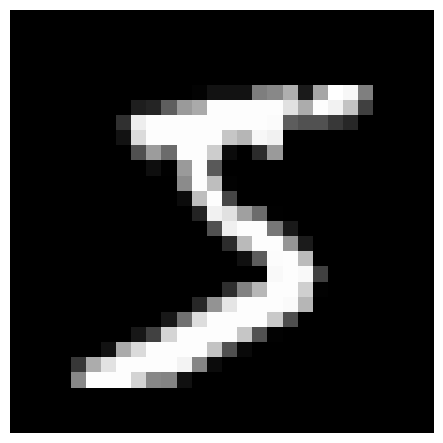

In [28]:
plt.imshow(train_images[0], cmap='gray')
plt.axis('off')

## BoW

In [ ]:
class BoW:
    def __init__(self,
                 images,
                 labels,
                 n_clusters,):

        self.images = images
        self.labels = labels
        self.n_clusters = n_clusters

    def get_sift_features(self, img):
        sift = cv2.SIFT_create()
        keypoints, descriptors = sift.detectAndCompute(img, None)
        return keypoints, descriptors


    def get_all_descriptors(self, imgs):
        all_descriptors = []
        for i, img in tqdm(enumerate(imgs), total=len(imgs)):
            descriptors = self.get_sift_features(img)[1]
            if descriptors is not None:
                all_descriptors.append(
                    {
                        'idx': i,
                        'descriptor': descriptors
                    })

        return np.asarray(all_descriptors)


    def get_clusters(self, descriptors, n_clusters):
        all_descriptors = []
        for descriptor in descriptors:
            all_descriptors.extend(descriptor['descriptor'])

        kmeans = KMeans(n_clusters=n_clusters, verbose=0)
        # all_descriptors = np.array(all_descriptors)
        # print(all_descriptors.shape)
        kmeans.fit(all_descriptors)
        return kmeans


    def img2histogram(self, descriptor, kmeans):
        word = kmeans.predict(descriptor.astype(np.float64))
        histogram = np.histogram(word, bins=len(kmeans.cluster_centers_)+1, density=True)[0]
        return histogram

    def fit(self, descriptors_path=None):
        if descriptors_path is not None:
            self.descriptors = np.load(descriptors_path, allow_pickle=True)
            print('Descriptors loaded')
        else:
            self.descriptors = self.get_all_descriptors(self.images)
            print('Descriptors computed')

        print('Computing KMeans')
        kmeans = self.get_clusters(descriptors=self.descriptors, n_clusters=self.n_clusters)
        print('KMeans Done')

        X, y = [], []

        for i, descriptor in tqdm(enumerate(self.descriptors), total=len(self.descriptors)):
            if descriptor['descriptor'] is not None:
                X.append(self.img2histogram(descriptor['descriptor'], kmeans))
                y.append(self.labels[i])

        return np.asarray(X), np.asarray(y)



In [ ]:
bag = BoW(images=train_images[:10000],
          labels=train_labels[:10000],
          n_clusters=100)

X, y = bag.fit(descriptors_path=None)


  0%|          | 0/10000 [00:00<?, ?it/s]

Descriptors computed
Computing KMeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans Done


  0%|          | 0/9769 [00:00<?, ?it/s]

In [ ]:
X[:10]

array([[0.32063492, 0.        , 0.        , ..., 0.        , 0.        ,
        0.32063492],
       [0.10631579, 0.        , 0.10631579, ..., 0.        , 0.        ,
        0.10631579],
       [0.22444444, 0.        , 0.        , ..., 0.        , 0.        ,
        0.22444444],
       ...,
       [0.24754902, 0.        , 0.        , ..., 0.        , 0.        ,
        0.12377451],
       [0.26578947, 0.        , 0.26578947, ..., 0.        , 0.        ,
        0.26578947],
       [0.2337963 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.2337963 ]])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.64485437, -0.77890583, -0.65967192, ..., -0.51180402,
        -0.59643135, -0.59890431],
       [-0.64485437,  0.92701991, -0.65967192, ...,  4.38132227,
        -0.59643135, -0.59890431],
       [-0.64485437,  0.07405704, -0.65967192, ...,  0.46682124,
        -0.59643135, -0.59890431],
       ...,
       [-0.64485437,  0.07405704, -0.65967192, ..., -0.51180402,
        -0.59643135,  2.00121685],
       [ 0.51351706, -0.77890583, -0.65967192, ..., -0.51180402,
        -0.59643135, -0.59890431],
       [-0.64485437, -0.77890583, -0.65967192, ..., -0.51180402,
        -0.59643135, -0.59890431]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7815, 101), (1954, 101), (7815,), (1954,))

<Axes: ylabel='Count'>

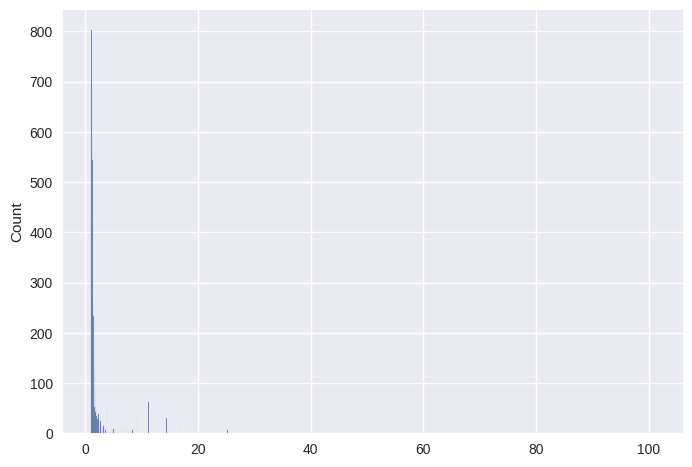

In [ ]:
sea.histplot(np.sum(X_train, axis=-1))

In [ ]:
svm_model = SVC(kernel='poly', C=1, degree=3)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.10696008188331628

In [ ]:
y_pred[:100]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [ ]:
y_test

array([0, 7, 2, ..., 7, 1, 0], dtype=uint8)

In [ ]:
y_pred = svm_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
accuracy

0.1146513115802943

## CNNs

In [5]:
batch_size = 128
lr = 1e-4

class MNISTDataset(Dataset):
    def __init__(self, images, labels):
        super().__init__()
        self.images = images
        self.labels = labels
        self.n_samples = len(self.images)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        img = torch.from_numpy(self.images[idx]).view(1, 28, 28)/255.0
        label = torch.tensor(self.labels[idx].astype(np.int64))

        return img.to(torch.float32), label.to(torch.int64)

train_dataset = MNISTDataset(train_images, train_labels)
val_dataset = MNISTDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
a, b = next(iter(train_loader))
a.shape, b.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = self.get_conv_block(1, 6, kernel_size=5, padding=2, stride=1)
        self.block2 = self.get_conv_block(6, 16, kernel_size=5, stride=1)
        self.block3 = self.get_conv_block(16, 120, kernel_size=5, stride=1)
        self.avgpool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def get_conv_block(self, in_c, out_c, kernel_size=5, padding=0, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=kernel_size, padding=padding, stride=stride),
            nn.Tanh(),
        )

    def forward(self, x):
        # 1, 28, 28
        x = self.block1(x) # 6, 28, 28
        x = self.avgpool(x) # 6, 14, 14
        x = self.block2(x) # 16, 10, 10
        x = self.avgpool(x) # 16, 5, 5
        x = self.block3(x) # 120, 1, 1

        x = x.view(-1, 120)

        x = nn.Tanh()(self.fc1(x)) # 84
        x = self.fc2(x) # 10
        return x


In [8]:
model = LeNet()
with torch.no_grad():
    print(model(a).shape)

torch.Size([128, 10])


In [14]:
from sklearn.metrics import accuracy_score

class Trainer:
    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 device,
                 logger=None,
                 lr=1e-4):

        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.logger = logger
        self.loss_fxn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 1e-4)
        self.accuracy_fxn = accuracy_score

    def training_step(self, x, y):
        y_pred = self.model(x)
        loss = self.loss_fxn(y_pred, y)
        acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss, acc

    def val_step(self, x, y):
        with torch.no_grad():
            y_pred = self.model(x)
            loss = self.loss_fxn(y_pred, y)
            acc = self.accuracy_fxn(y.cpu().numpy(), np.argmax(y_pred.detach().cpu().numpy(), axis=-1))

        return loss, acc

    def go_one_epoch(self, loader, step_fxn):
        loss, acc = 0, 0
        for x, y in loader:
            x, y = x.to(self.device), y.to(self.device)
            loss_batch, acc_batch = step_fxn(x, y)
            loss, acc = loss + loss_batch, acc + acc_batch

        return loss/len(loader), acc/len(loader)

    def train(self, epochs=20):
        for epoch in tqdm(range(epochs)):
            train_loss, train_acc = self.go_one_epoch(self.train_loader, self.training_step)
            val_loss, val_acc = self.go_one_epoch(self.val_loader, self.val_step)

            print(f"[{epoch + 1}] train:[loss:{train_loss:.4f}, acc:{train_acc:.4f}] val:[loss:{val_loss:.4f}, acc:{val_acc:.4f}]")
            
            if self.logger is not None:
                self.logger.log({
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'train_acc': train_acc,
                    'val_acc': val_acc 
                })


In [15]:
wandb.init(project='CV-2024-A2', 
           name='LeNet',
           config={
               'lr': lr,
               'batch_size': batch_size,
               'optimizer': 'adam',
               'num_conv_layers': 3
           })

In [17]:
trainer = Trainer(
    model=LeNet(),
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    logger=wandb,
    lr=lr
)

In [18]:
trainer.train()

  0%|          | 0/20 [00:00<?, ?it/s]

[1] train:[loss:1.1827, acc:0.7019] val:[loss:0.5390, acc:0.8690]
[2] train:[loss:0.4361, acc:0.8852] val:[loss:0.3428, acc:0.9064]
[3] train:[loss:0.3203, acc:0.9086] val:[loss:0.2741, acc:0.9200]
[4] train:[loss:0.2625, acc:0.9228] val:[loss:0.2269, acc:0.9312]
[5] train:[loss:0.2224, acc:0.9340] val:[loss:0.1940, acc:0.9406]
[6] train:[loss:0.1925, acc:0.9427] val:[loss:0.1697, acc:0.9490]
[7] train:[loss:0.1687, acc:0.9491] val:[loss:0.1484, acc:0.9556]
[8] train:[loss:0.1500, acc:0.9550] val:[loss:0.1358, acc:0.9602]
[9] train:[loss:0.1339, acc:0.9604] val:[loss:0.1227, acc:0.9649]
[10] train:[loss:0.1205, acc:0.9646] val:[loss:0.1089, acc:0.9679]
[11] train:[loss:0.1095, acc:0.9676] val:[loss:0.1015, acc:0.9692]
[12] train:[loss:0.0994, acc:0.9711] val:[loss:0.0949, acc:0.9705]
[13] train:[loss:0.0912, acc:0.9733] val:[loss:0.0879, acc:0.9730]
[14] train:[loss:0.0837, acc:0.9753] val:[loss:0.0807, acc:0.9746]
[15] train:[loss:0.0775, acc:0.9769] val:[loss:0.0758, acc:0.9751]
[16]

In [27]:
api = wandb.Api()
run = api.run(f"CV-2024-A2/qph9kyhs")

In [20]:
run

<Run fk280/CV-2024-A2/qph9kyhs (running)>